#Light GBM Notebook

Trying LGBM based on some of the discussions on kaggle around how to approach this competition in years past due to the large amount of data provided. The biggest advantages to using this approach are as follows: 


*   Can handle large data sets
*   LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up). (source: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)



In [1]:
!pip install fast_ml --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from fast_ml.model_development import train_valid_test_split
import lightgbm as lgb
import seaborn as sns

In [6]:
#Read in the new data with additional feature engineering. 
dtypes = {
    'ip': 'category',
    'app': 'category',
    'device': 'category',
    'os': 'category',
    'channel': 'category',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'category', 
    'hour' : 'category',
    'day' : 'category'
}

df3 = pd.read_csv('/content/train_v3_neat.csv', dtype=dtypes)
df3.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,2017-11-06 14:53:23,NaN,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,2017-11-06 15:45:05,NaN,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,2017-11-06 15:50:54,NaN,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,2017-11-06 15:57:36,NaN,0,15,6,1,269,53,11.134387,271,1490016144,31749


In [7]:
df3 = df3.drop(['click_time', 'attributed_time'], axis=1)
df3.head()

,ip,app,device,os,channel,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,0,15,6,1,269,53,11.134387,271,1490016144,31749


###Feature Selection & Data Splitting

Found this library here: https://www.kaggle.com/code/nextbigwhat/train-valid-test-split-instead-of-train-test-split/notebook

In [8]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(df3, 
                                                                            target = 'is_attributed', 
                                                                            train_size=0.8, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.1)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)


(765476, 14)
(765476,)
(95685, 14)
(95685,)
(95685, 14)
(95685,)


(None, None)

In [9]:
#Building a very simple LGM Model
#default settings are as follows for LGBMClassifier
               #(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
               #n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
               #min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
               #subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
               #random_state=None, n_jobs=None, importance_type='split', **kwargs)
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(x_train, y_train)

LGBMClassifier()

In [16]:
#trying to improve accuracy from (93.55%) of LGM Model:
#Will reduce the learning rate to 0.01- made it worse with an accuracy score of 91.90%
#Reducing the subsample_for_bin (number of samples for each bin) to 100,000 did increase accuracy by about 0.10%

lgb_model = lgb.LGBMClassifier(subsample_for_bin=100000, random_state=123)
lgb_model.fit(x_train, y_train)

LGBMClassifier(random_state=123, subsample_for_bin=100000)

In [17]:
#predicting the labes on x_valid
y_valid_pred = lgb_model.predict(x_valid)

In [18]:
#Checking the accuracy of our model based on our predictions
accuracy=accuracy_score(y_valid_pred, y_valid)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid, y_valid_pred)))

LightGBM Model accuracy score: 0.9391


In [19]:
#looking at the accuracy of our training set
y_pred_train = lgb_model.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9434


In [13]:
#Checking for overfitting
#They are close and do not suspect any overfitting occuring. 
print('Training set score: {:.4f}'.format(lgb_model.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(lgb_model.score(x_valid, y_valid)))

Training set score: 0.9436
Test set score: 0.9391


Confusion Matrix
 [[48081  1899]
 [ 3928 41777]]


<Axes: >

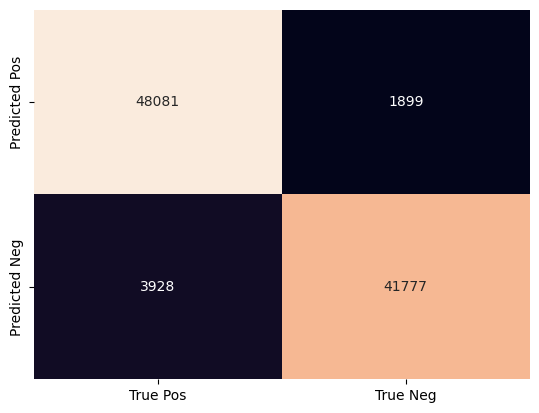

In [14]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
print('Confusion Matrix\n', conf_matrix)

#Heatmap
conf_matrix_hm = pd.DataFrame(data=conf_matrix, columns=['True Pos', 'True Neg'], index=['Predicted Pos', 'Predicted Neg'])
sns.heatmap(conf_matrix_hm, annot=True, fmt='d', cbar=False)

In [15]:
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     49980
           1       0.96      0.91      0.93     45705

    accuracy                           0.94     95685
   macro avg       0.94      0.94      0.94     95685
weighted avg       0.94      0.94      0.94     95685



In [22]:
#predicting the labes on x_valid
y_test_pred = lgb_model.predict(x_test)

In [23]:
accuracy=accuracy_score(y_test_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

LightGBM Model accuracy score: 0.9356
